# Project: Identify Customer Segments




## Introduction
The real-life data in this project concerns a company that performs mail-order sales in Germany, provided by AZ Direct and Arvato Finance Solution.

The goal of this project is to identify facets of the population that are most likely to be purchasers of their products for a mailout campaign. Unsupervised learning techniques are used to organize the general population into clusters for checking which of them comprise the main user base for the company. 

There are a few steps of data cleaning before the machine learning techniques have been applied.

### Data

The main data for this project consist of two files:

- `Udacity_AZDIAS_Subset.csv`: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- `Udacity_CUSTOMERS_Subset.csv`: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The **columns** in the *general* demographics file and *customers* data file are the
**same**. 

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their **household**, **building**, and **neighborhood**. 

### Features
There are another two documents explaining features:

- `AZDIAS_Feature_Summary.csv`: Summary of  demographics data 
       features; 85 features (rows) x 4 columns

- `Data_Dictionary.md`: Detailed information file about the 
       features

#### Latent Features

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level features
 7. RR1 neighborhood features
 8. PLZ8 macro-cell features
 9. Community-level features

In [0]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

In [6]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/dsnd_p1_charity


In [11]:
# CPU!!! --gdrive
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/dsnd_p3_identify_customer_segments')
!pwd

/content/gdrive/My Drive/Colab Notebooks/dsnd_p3_identify_customer_segments


In [215]:
!ls data

AZDIAS_Feature_Summary.csv	 Data_Dictionary.md
azdias_updated_missing_data.csv  Udacity_AZDIAS_Subset.csv
data_dictionary.ipynb		 Udacity_CUSTOMERS_Subset.csv


In [0]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle

# magic word for producing visualizations in notebook
%matplotlib inline

In [0]:
my_color = ['#42bff4', '#f9ace9']

## Step 0: Load the Data

You will use this information to **cluster** the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset **fit** into those created clusters. 

The hope here is that certain clusters are*** over-represented*** in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.



To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary.

> **Tip**:  Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 


#### General Demographics Data

In [0]:
# Load in the general demographics data.
azdias = pd.read_csv('data/Udacity_AZDIAS_Subset.csv', sep = ';')

In [219]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.sample(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
747199,-1,1,2,4.0,1,5,2,4,4,4,...,2.0,4.0,2.0,1.0,2.0,4.0,3.0,2.0,7.0,3.0


In [220]:
azdias.shape

(891221, 85)

In [0]:
azdias.info()

#### Feature Summary File

In [0]:
# Load in the feature summary file.
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.set_index('attribute', inplace=True)

In [306]:
feat_info.sample(5)

,information_level,type,missing_or_unknown
attribute,,,
GEBAEUDETYP,building,categorical,"[-1,0]"
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
SEMIO_PFLICHT,person,ordinal,"[-1,9]"
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

First of all, you should **assess** the demographics data in terms of missing data. 



#### Step 1.1.1: Convert Missing Value Codes to NaNs
The **fourth** column of the **feature summary** (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate*** missing or unknown data***. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a **string** object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [0]:
# Identify missing or unknown data values and convert them to NaNs.
# In 'feat_info', the column 'missing_or_unknown' (type: object) shows missing values (e.g. -1, 0)
for col in azdias.columns:
  print(col)
  if azdias[col].dtype == 'float64':
    azdias[col] = azdias[col].map(lambda x: np.nan if '{:.0f}'.format(x) in feat_info.loc[col].missing_or_unknown else x)  
  else:
    azdias[col] = azdias[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown else x)
    
# This code cell is retrived from 
# https://github.com/atahmasb/Identify-Customer-Segments-with-Arvato/blob/master/Identify_Customer_Segments.ipynb

In [0]:
#Save the result into a new df as this step takes a long time to run  

#azdias.to_csv('data/azdias_updated_missing_data.csv', sep=';', index = False)

In [0]:
df_new = pd.read_csv('data/azdias_updated_missing_data.csv', sep=';')

In [313]:
df_new.shape

(891221, 85)

In [277]:
df_new.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,NaN,NaN,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,...,3.0,3.0,NaN,0.0,NaN,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,...,2.0,2.0,2.0,0.0,NaN,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,...,2.0,4.0,2.0,NaN,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [0]:
# Calculate the percentage of missing values of each column
missing = df_new.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

# columns have more than 20% missing values
missing_20 = missing[missing >20]

In [316]:
print(f"{len(missing)} out of {df_new.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")
print(f'{len(missing_20)} columns have more than 20% missing values.')


84 out of 85 columns contain missing values, from 0.7% to 128.1%.
38 columns have more than 20% missing values.


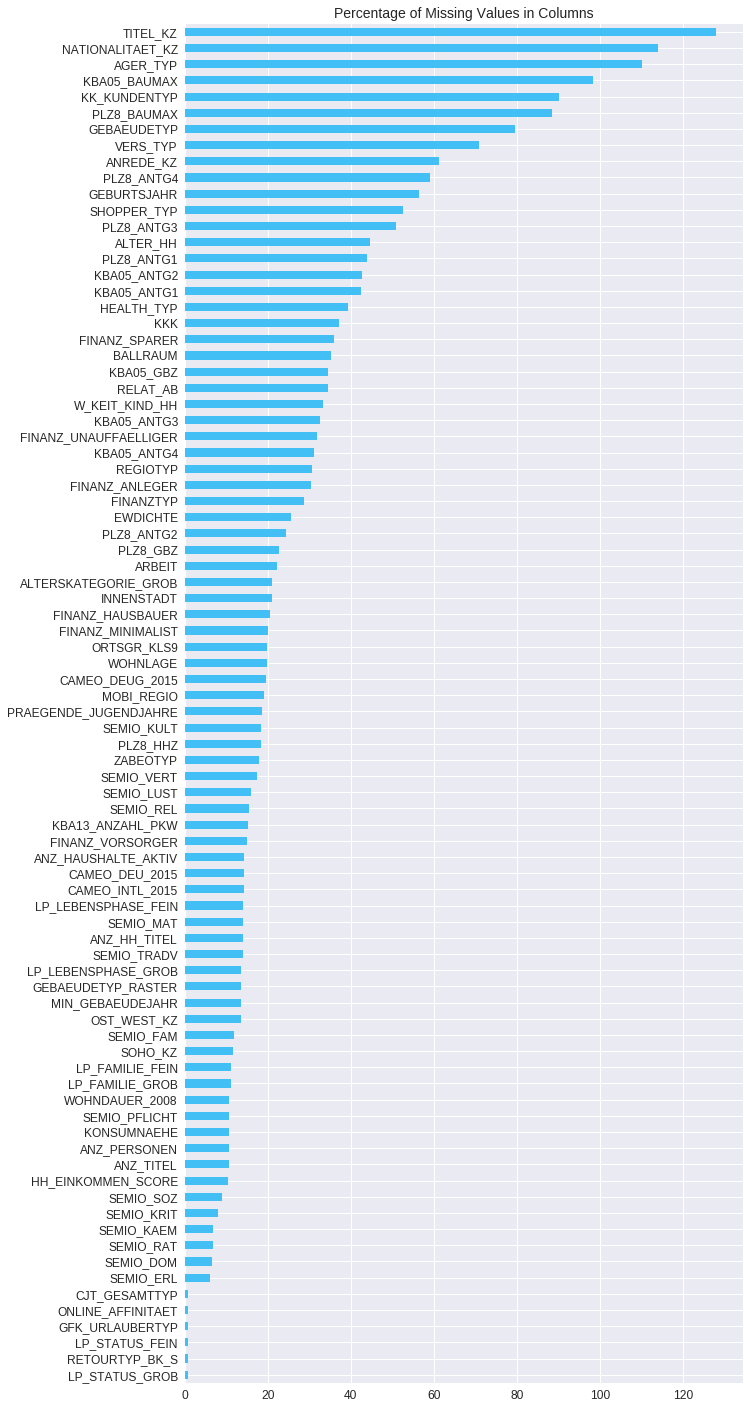

In [317]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 25), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

In [0]:
# Remove the outlier columns from the dataset / feature summary. 

# Drop columns that contain 20% missing values
for col in missing_20.index:
  
  # Dataset
  df_new.drop(col, axis = 1, inplace = True)
  
  # Feature Summary
  feat_info.drop([col], inplace = True)
  

In [319]:
df_new.shape

(891221, 47)

In [320]:
feat_info.shape

(47, 3)

In [321]:
# missing_20.index

Index(['FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'INNENSTADT',
       'ALTERSKATEGORIE_GROB', 'ARBEIT', 'PLZ8_GBZ', 'PLZ8_ANTG2', 'EWDICHTE',
       'FINANZTYP', 'FINANZ_ANLEGER', 'REGIOTYP', 'KBA05_ANTG4',
       'FINANZ_UNAUFFAELLIGER', 'KBA05_ANTG3', 'W_KEIT_KIND_HH', 'RELAT_AB',
       'KBA05_GBZ', 'BALLRAUM', 'FINANZ_SPARER', 'KKK', 'HEALTH_TYP',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'PLZ8_ANTG1', 'ALTER_HH', 'PLZ8_ANTG3',
       'SHOPPER_TYP', 'GEBURTSJAHR', 'PLZ8_ANTG4', 'ANREDE_KZ', 'VERS_TYP',
       'GEBAEUDETYP', 'PLZ8_BAUMAX', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
       'AGER_TYP', 'NATIONALITAET_KZ', 'TITEL_KZ'],
      dtype='object')

#### Discussion 1.1.2: Assess Missing Data in Each Column

84 out of 85 columns contain missing values, ranging from 0.54% to 88.91%. From the bar chart, it can be seen that the missing values of most columns are less than 16.35%, and the 12 columns at the top are outliers. Thus, they are removed from our dataset.

The columns removed from the dataset includes:

'FINANZ_MINIMALIST', 'FINANZ_HAUSBAUER', 'INNENSTADT',
       'ALTERSKATEGORIE_GROB', 'ARBEIT', 'PLZ8_GBZ', 'PLZ8_ANTG2', 'EWDICHTE',
       'FINANZTYP', 'FINANZ_ANLEGER', 'REGIOTYP', 'KBA05_ANTG4',
       'FINANZ_UNAUFFAELLIGER', 'KBA05_ANTG3', 'W_KEIT_KIND_HH', 'RELAT_AB',
       'KBA05_GBZ', 'BALLRAUM', 'FINANZ_SPARER', 'KKK', 'HEALTH_TYP',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'PLZ8_ANTG1', 'ALTER_HH', 'PLZ8_ANTG3',
       'SHOPPER_TYP', 'GEBURTSJAHR', 'PLZ8_ANTG4', 'ANREDE_KZ', 'VERS_TYP',
       'GEBAEUDETYP', 'PLZ8_BAUMAX', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
       'AGER_TYP', 'NATIONALITAET_KZ', 'TITEL_KZ'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. 

Divide the data into two subsets: 
- one for data points that are **above** some threshold for missing values, and 
- a second subset for points **below** that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are **similar** or different* **bold text** between the two groups*. Select at least **five** of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [0]:
# How much data is missing in each row of the dataset?
missing_r = df_new.isnull().sum(axis=1)


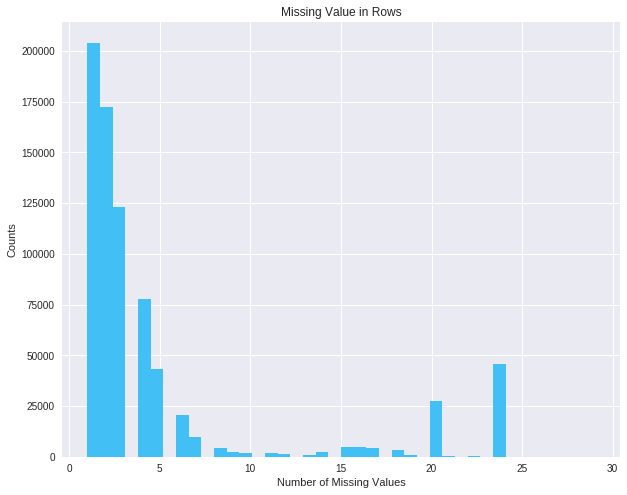

In [323]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', bins=40, figsize=(10,8), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

In [0]:
# Divide the data into two subsets: 5 missing values

df = df_new[missing_r <= 5]

df_more_missing = df_new[missing_r > 5]


In [0]:
def plot_comparison(df1, df2, n):
  
  cols = df1.columns.tolist()
  
  # Randomly reorder column names
  shuffle(cols) # shuffle works in place, and returns None
  
  for i in range(1, n+1):
    plt.figure(i, figsize=(12, 4))
    
    #subplot(nrows, ncols, index)
    plt.subplot(1, 2, 1)
    sns.countplot(x = df1[cols[i]], color = my_color[0], edgecolor='.9')
    plt.title(cols[i] + "(Data Kept)")

    plt.subplot(1, 2, 2)
    sns.countplot(x = df1[cols[i]], color = my_color[1], edgecolor='.9')
    plt.title(cols[i] + "(Data Rejected)")
    
    plt.subplots_adjust(wspace = 0.5)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


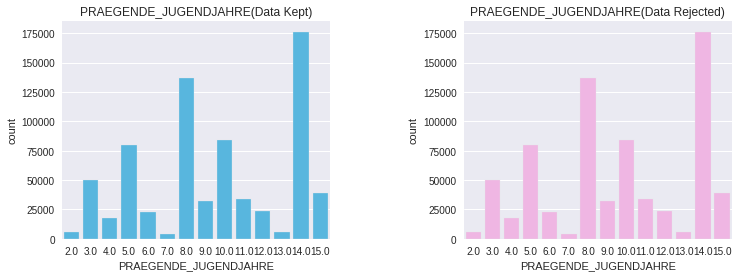

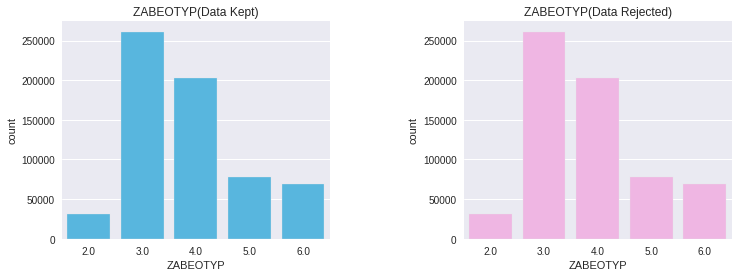

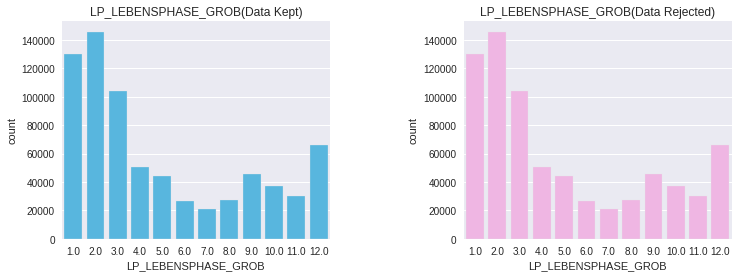

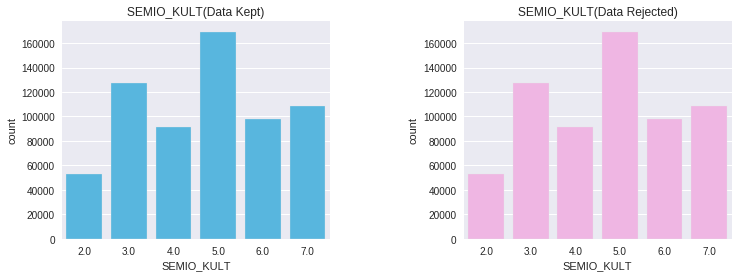

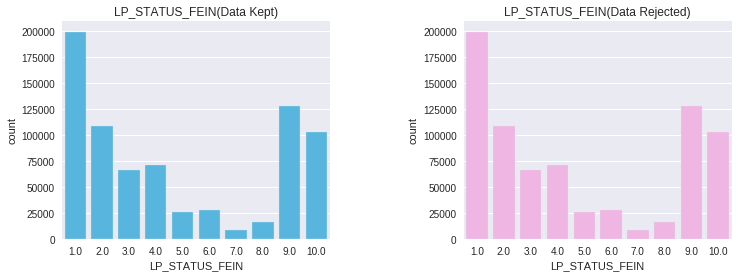

In [326]:
plot_comparison(df, df_more_missing, 5)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with lots of missing values  in rows are very similar to the data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded **numerically**, you need to make a few encoding changes or additional assumptions to be able to make progress. 

In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the **third** column of the feature summary (`feat_info`) for a summary of types of measurement.
- For **numeric** and **interval** data, these features can be kept without changes.
- Most of the variables in the dataset are **ordinal** in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: **categorical**, and '**mixed**'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.


In [327]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        24
categorical    12
numeric         6
mixed           5
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For **categorical** data, you would ordinarily need to encode the levels as **dummy** variables. Depending on the number of categories, perform one of the following:
- For binary (**two-level**) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on** non-numeric** values. For this one, you need to **re-encode** the values as numbers or create a dummy variable.
- For **multi-level** categoricals (three or more values), you can choose to encode the values using multiple **dummy** variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. 

As always, document your choices in the Discussion section.

##### Step 1.2.1.1

Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

In [0]:
# Put Categorical Features into a list
feat_cate = feat_info.query('type == "categorical"').index.tolist()

In [0]:
# build a df to show levels & types
feat_cate_df = pd.DataFrame(index = feat_cate, columns = ['levels', 'type'])

for feature in feat_cate:
  
  # number of levels
  levels = df[feature].value_counts().shape[0]
  
  # types
  feat_type = df[feature].dtypes
  
  # fill the df
  feat_cate_df.loc[feature] = [levels, feat_type]

In [330]:
feat_cate_df.sort_values('levels')

,levels,type
SOHO_KZ,1,float64
GREEN_AVANTGARDE,2,int64
OST_WEST_KZ,2,object
LP_FAMILIE_GROB,5,float64
LP_STATUS_GROB,5,float64
ZABEOTYP,5,float64
CJT_GESAMTTYP,6,float64
CAMEO_DEUG_2015,8,float64
LP_STATUS_FEIN,10,float64
LP_FAMILIE_FEIN,11,float64


##### Step 1.2.1.2
Re-encode categorical variable(s) to be kept in the analysis.

**Re-Encode Non-Numeric Binary Variable**

3.6. `OST_WEST_KZ` -- 
Building location via former East / West Germany (GDR / FRG)

- O: East (GDR)
- W: West (FRG)

In [0]:
# Re-encode 'OST_WEST_KZ': 2-level obj
# O: East (GDR)
# W: West (FRG)

df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0, 'W': 1})

In [336]:
df['OST_WEST_KZ'].value_counts()

1    594816
0    159246
Name: OST_WEST_KZ, dtype: int64

**One-Hot-Encoding**

1.14. `LP_FAMILIE_GROB` --
Family type, rough scale

- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)

1.16. `LP_STATUS_GROB` -- Social status, rough scale

- 1: low-income earners (maps to 1-2 in fine scale)
- 2: average earners (maps to 3-5 in fine scale)
- 3: independents (maps to 6-7 in fine scale)
- 4: houseowners (maps to 8-9 in fine scale)
- 5: top earners (maps to 10 in fine scale)

1.4. `CJT_GESAMTTYP` -- 
Customer-Journey-Typology: preferred information and buying channels for consumer

- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour

4.1.` CAMEO_DEUG_2015`
German CAMEO: Wealth / Life Stage Typology, rough scale

- 1: upper class
- 2: upper middleclass
- 3: established middleclass
- 4: consumption-oriented middleclass
- 5: active middleclass
- 6: low-consumption middleclass
- 7: lower middleclass
- 8: working class
- 9: urban working class


In [0]:
df = pd.get_dummies(data = df, columns=['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CJT_GESAMTTYP', 'CAMEO_DEUG_2015'])

In [345]:
df.shape

(754062, 67)

In [0]:
#df.info()

**Drop Columns: **

The columns contains information that is  less important or similar to others are removed: 

- ZABEOTYP -- Energy consumption typology 
- GFK_URLAUBERTYP -- Vacation habits
- LP_FAMILIE_FEIN -- Family type, fine scale (Similar as 1.14 LP_FAMILIE_GROB)
- CAMEO_DEU_2015 -- Wealth / Life  (44 levels are too much)
- SOHO_KZ (only have 1 category)

In [0]:
df.drop(columns = ['ZABEOTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015', 'SOHO_KZ'], inplace = True)

In [0]:
df.to_csv('data/azdias_new.csv', sep=';', index = False)

#### Discussion 1.2.1: Re-Encode Categorical Features

The non-numeric binary variable, `OST_WEST_KZ`,  has been re-encoded by 0 and 1.

`LP_FAMILIE_GROB`,  `CJT_GESAMTTYP`,  `LP_STATUS_GROB` and ` CAMEO_DEUG_2015` have been directly put into dummy variables.

The following columns are removed as the information they contains is  less important or similar to others: 

- `ZABEOTYP`
- `GFK_URLAUBERTYP`
- `LP_FAMILIE_FEIN`
- `CAMEO_DEU_2015`
- `SOHO_KZ`

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [0]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.



In [0]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.



#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [0]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [0]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [0]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [0]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [0]:
# Apply feature scaling to the general population demographics data.



### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [0]:
# Apply PCA to the data.



In [0]:
# Investigate the variance accounted for by each principal component.



In [0]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [0]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [0]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [0]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [0]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [0]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [0]:
# Load in the customer demographics data.
customers = 

In [0]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [0]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [0]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [0]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.